In [5]:
import os
import sys
from PIL import Image
from pathlib import Path
# import matplotlib.pyplot as plt 
from urllib.request import urlretrieve

# from kaggle_secrets import UserSecretsClient

import numpy as np
import pandas as pd
import torch
# import wandb

In [6]:
class CFG:
    device = "cuda"
    seed = 42
    embedding_length = 384
    model_name = "coca_ViT-L-14"
    model_checkpoint_path = "mscoco_finetuned_CoCa-ViT-L-14-laion2B-s13B-b90k.bin"

In [30]:
paths = ['coco_gen_ex/files_ex_1.csv', 'coco_gen_ex_2/files_ex_2.csv']

In [31]:
files = pd.read_csv('coco_gen/files.csv')

for path in paths:
    files = pd.concat([files, pd.read_csv(path)])

In [32]:
files

,path,prompt
0,A bicycle replica with a clock as the front wh...,coco_gen/9b33bcb8f4d14e90c70b6c0a5ffd4cb16168c...
1,A room with blue walls and a white sink and door.,coco_gen/0c826fff5e822adaecbb277cb0d3144e062f9...
2,A car that seems to be parked illegally behind...,coco_gen/4b247ab305244f972b28b1bca05b7e26ad0ff...
3,A large passenger airplane flying through the ...,coco_gen/9bd3195290c1368d3db7d5d6ed1fcf3b92fdc...
4,There is a GOL plane taking off in a partly cl...,coco_gen/d775a29f04b95758f128d5fbd621534951bd2...
...,...,...
9995,Two giraffes standing in a grass field near so...,coco_gen_ex_2/6788a821cc73d5836ec791ed1ba218a3...
9996,Two giraffes standing in a grass field near so...,coco_gen_ex_2/05fd7aead907e27f97eade4b0aacb770...
9997,Two giraffes standing in a grass field near so...,coco_gen_ex_2/686ee2dd0b309bd763bda51bcba39521...
9998,A tablet showing a video feed of a baseball ga...,coco_gen_ex_2/eee28e79c91882af4fda686b8027b228...


In [33]:
files = files.rename(columns={'path': 'title', 'prompt': 'filepath'})

In [34]:
files.to_csv('train_data.csv', index=False, sep="\t")

In [8]:
!python -m training.main \
    --dataset-type "csv" \
    --train-data "train_data.csv" \
    --warmup 1000 \
    --batch-size 4 \
    --lr 1e-5 \
    --wd 0.1 \
    --epochs 1 \
    --workers 2 \
    --model 'coca_ViT-L-14' \
    --pretrained 'mscoco_finetuned_CoCa-ViT-L-14-laion2B-s13B-b90k.bin' \
    --coca-contrastive-loss-weight 0 \
    --coca-caption-loss-weight 1 \
    --log-every-n-steps 100

2023-04-12,16:11:59 | INFO | Running with a single process. Device cuda:0.
2023-04-12,16:11:59 | INFO | Loaded coca_ViT-L-14 model config.
2023-04-12,16:12:02 | INFO | Loading pretrained coca_ViT-L-14 weights (mscoco_finetuned_CoCa-ViT-L-14-laion2B-s13B-b90k.bin).
2023-04-12,16:12:04 | INFO | Model:
2023-04-12,16:12:04 | INFO | CoCa(
  (text): TextTransformer(
    (token_embedding): Embedding(49408, 768)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
           

In [24]:
pd.read_csv('train_data.csv', sep='\t')

,path,prompt
0,A bicycle replica with a clock as the front wh...,coco_gen/9b33bcb8f4d14e90c70b6c0a5ffd4cb16168c...
1,A room with blue walls and a white sink and door.,coco_gen/0c826fff5e822adaecbb277cb0d3144e062f9...
2,A car that seems to be parked illegally behind...,coco_gen/4b247ab305244f972b28b1bca05b7e26ad0ff...
3,A large passenger airplane flying through the ...,coco_gen/9bd3195290c1368d3db7d5d6ed1fcf3b92fdc...
4,There is a GOL plane taking off in a partly cl...,coco_gen/d775a29f04b95758f128d5fbd621534951bd2...
...,...,...
29994,Two giraffes standing in a grass field near so...,coco_gen_ex_2/6788a821cc73d5836ec791ed1ba218a3...
29995,Two giraffes standing in a grass field near so...,coco_gen_ex_2/05fd7aead907e27f97eade4b0aacb770...
29996,Two giraffes standing in a grass field near so...,coco_gen_ex_2/686ee2dd0b309bd763bda51bcba39521...
29997,A tablet showing a video feed of a baseball ga...,coco_gen_ex_2/eee28e79c91882af4fda686b8027b228...


In [7]:
import open_clip
import torch

model, _, transform = open_clip.create_model_and_transforms(
  model_name="coca_ViT-L-14",
  pretrained="logs/2023_04_12-16_21_27-model_coca_ViT-L-14-lr_1e-05-b_6-j_2-p_amp/checkpoints/epoch_3.pt"
)

/home/slvt/.conda/envs/coco/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
! ls logs/2023_04_12-16_21_27-model_coca_ViT-L-14-lr_1e-05-b_6-j_2-p_amp/checkpoints/epoch_3.pt

epoch_1.pt  epoch_2.pt	epoch_3.pt


In [10]:
!wget https://i.imgur.com/IYw8RoT.png -O img.jpg

--2023-04-12 15:41:58--  https://i.imgur.com/IYw8RoT.png
Resolving i.imgur.com (i.imgur.com)... 151.101.84.193
Connecting to i.imgur.com (i.imgur.com)|151.101.84.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1079510 (1,0M) [image/png]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]   1,03M  3,38MB/s    in 0,3s    

2023-04-12 15:41:59 (3,38 MB/s) - ‘img.jpg’ saved [1079510/1079510]



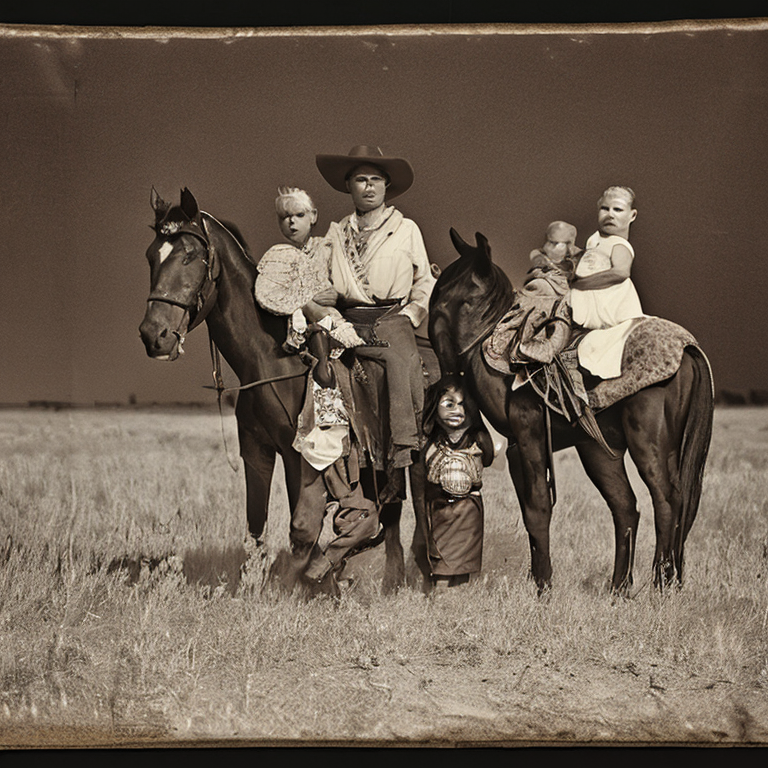

In [11]:
from IPython.display import Image
Image('cat.jpg')

In [8]:
from PIL import Image
im = Image.open("img.jpg").convert("RGB")
im = transform(im).unsqueeze(0)

with torch.no_grad(), torch.cuda.amp.autocast():
  generated = model.generate(im)

print(open_clip.decode(generated[0]).split("<end_of_text>")[0].replace("<start_of_text>", ""))

a picture of an old western family and their horses in the 1 9 2 0 's era . is a beautiful photograph of the little girl on the 
